# week14

MNIST 데이터를 활용하여 손글씨를 생성하는 프로그램을 작성하시오.

- 입력 데이터셋
    - MNIST dataset
    - 0~9 손글씨 이미지에 대한 픽셀 값 데이터
- 문제
    - 이미지의 픽셀 값을 입력으로 하여, 해당 이미지가 0~9 중에 어떤 숫자인지 분류

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
# torchvision - 데이터 가공해둠, 관련 모듈들
from matplotlib import pyplot as plt


# 28 * 28 의 0~255 사이 숫자
# Z -> G -> image
# 분포로 만들어진 이미지와 진짜 이미지 비교
# 분포와 이미지와의 관계 학습


################################
#      Discriminator 설계      #
################################

class MNIST_Discriminator(nn.Module):
  def __init__(self, config):
    super(MNIST_Discriminator, self).__init__()

    # 입력층 노드 수
    self.inode = config["d_input_node"] # 28 * 28
    # 은닉층 노드 수
    self.hnode = config["d_hidden_node"]
    # 출력층 노드 수: 분류해야 하는 레이블 수
    self.onode = config["d_output_node"] # - 0 또는 1 => real or fake

    # 신경망 설계
    self.net = nn.Sequential(nn.Linear(self.inode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True), # 계속 확장
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.onode, bias=True),
                             nn.Sigmoid()) # Sigmoid -> 0~1 ; real or fake
    
  def forward(self, input_features):
    hypothesis = self.net(input_features)
    return hypothesis


################################
#        Generator 설계        #
################################

class MNIST_Generator(nn.Module):
  def __init__(self, config):
    super(MNIST_Generator, self).__init__()

    # 입력층 노드 수
    self.inode = config["g_input_node"] # Z(분포)의 크기 ex. 일반적으로 28*28 보다 작은 값
    # 은닉층 노드 수
    self.hnode = config["g_hidden_node"]
    # 출력층 노드 수: 생성해야 하는 노드 수
    self.onode = config["g_output_node"] # 28*28 ; 이미지를 생성해야 하기 때문

    # 신경망 설계
    self.net = nn.Sequential(nn.Linear(self.inode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.onode, bias=True),
                             nn.Tanh())

  def forward(self, input_features):
    hypothesis = self.net(input_features)
    return hypothesis

In [9]:
def imshow_grid(img): 
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [10]:
# 데이터 읽기 함수
def load_dataset():
  # 데이터 셋을 설정한 정규분포 대로 가져와라
  standardizator = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))])

  # MNIST dataset
  # data 폴더 - 우리가 실험할 MNIST data의 root 디렉토리
  # 전처리 되어있는 데이터를 가져옴
  train_X = datasets.MNIST(root='/gdrive/My Drive/ml_colab/week14/data/', train=True, transform=standardizator, download=True)
  return train_X

In [11]:
def get_noise(batch_size=16, g_input_node=100): # 100 차원에서 28*28 을
    return torch.randn(batch_size, g_input_node) # randn 에서 뒤에 n == 정규분포

def do_test(model, input_node):
  # 평가 모드 셋팅
  model.eval()

  with torch.no_grad():

    X = get_noise(g_input_node=input_node).cuda()
    hypothesis = model(X)
    hypothesis_ = hypothesis.reshape((-1,28,28)).unsqueeze(1)
    imshow_grid(hypothesis_)  

In [14]:
# 모델 학습 함수
def train(config):

  # Discriminator와 Generator 모델 생성
  # 이곳을 채우세요.
  D = MNIST_Discriminator(config).cuda()
  G = MNIST_Generator(config).cuda()

  # 데이터 읽기
  input_features = load_dataset()
  
  # DataLoader를 통해 배치(batch) 단위로 데이터를 나누고 셔플(shuffle)
  train_dataloader = DataLoader(input_features, shuffle=True, batch_size=config["batch_size"])

  # 바이너리 크로스엔트로피 비용 함수 
  loss_func = nn.BCELoss()

  # Discriminator와 Generator 옵티마이저 함수 지정
  # 이곳을 채우세요.
  D_optimizer = torch.optim.Adam(D.parameters(), lr=config["learn_rate"])
  G_optimizer = torch.optim.Adam(G.parameters(), lr=config["learn_rate"])

  for epoch in range(config["epoch"]+1):

    # Discriminator와 Generator 학습 모드 셋팅
    D.train()
    G.train()
    
    # epoch 마다 평균 비용을 저장하기 위한 리스트
    D_costs, G_costs = [], []

    for (step, batch) in enumerate(train_dataloader):

      # batch = (input_features[step], labels[step])*batch_size
      # .cuda()를 통해 메모리에 업로드
      batch = tuple(t.cuda() for t in batch)

      # 배치 크기 만큼 입력 데이터 읽기 
      input_features, _ = batch  # _: label
      input_features = input_features.view(-1,config['d_input_node'])  # -1: 행, config["d_input_node"]: 28*28
      
      ################################
      #      Discriminator 학습      #
      ################################

      # 역전파 변화도 초기화
      D_optimizer.zero_grad()
 
      # 진짜에 대한 비용 계산
      real_hypothesis = D(input_features)
      real_labels = Variable(torch.ones(config["batch_size"],1)).cuda()
      real_cost = loss_func(real_hypothesis, real_labels) # 비교
      
      # 가짜에 대한 비용 계산
      fake_input_features = get_noise(config["batch_size"],config["g_input_node"]).cuda()
      fake_hypothesis = D(G(fake_input_features)) # G: generator 가 이미지 생성 -> D 에 입력 // D 가 fake 라고 판단 -> 0
      # fake_input_features = Z
      fake_labels = Variable(torch.zeros(config["batch_size"],1)).cuda() # 배치 사이즈만큼 0을 만들어 냄
      # 이곳을 채우세요
      fake_cost = loss_func(fake_hypothesis, fake_labels) # fake_labels = 0

      # 전체 비용 역전파 수행
      # 이곳을 채우세요.
      total_cost = real_cost + fake_cost
      total_cost.backward() # 역전파
      D_optimizer.step()

      # 현재 batch의 스텝 별 Discrimnator 비용 저장
      D_costs.append(total_cost.data.item())


      ################################
      #        Generator 학습        #
      ################################
 
      # 역전파 변화도 초기화
      G_optimizer.zero_grad()

      # 가짜에 대한 비용 계산
      fake_input_features = get_noise(config["batch_size"],config["g_input_node"]).cuda()
      # 이곳을 채우세요.
      fake_hypothesis = D(G(fake_input_features))
      fake_labels = Variable(torch.ones(config["batch_size"],1)).cuda()
      # 이곳을 채우세요.
      fake_cost = loss_func(fake_hypothesis, fake_labels)

      """
      Discriminator와 Generator의 fake_labels, fake_cost 차이
      torch.ones -> 0 / 1 차이
      
      fake를 넣었을 때 0이 아닌 1이 되도록 해야 함......... 강의부터 드ㅡㄷ자...뭐라는.
      fake_hypothesis, fake_labels
      fake 넣었는데 G가 1을 뱉으면 -> 잘한 것. 1과 비교해야 하므로, 동일한 값

      이해가 안돼요^~^~
      """

      # 가짜 생성 비용 역전파 수행
      fake_cost.backward()
      G_optimizer.step()

      # 현재 batch의 스텝 별 Generator 비용 저장
      G_costs.append(fake_cost.data.item())
    
    # 10 에폭마다 중간 결과 출력 및 저장
    if epoch%10 == 0:
    
      # 평균 비용 출력
      print("Avg Loss D={0:f}, Avg Loss G={1:f}".format(np.mean(D_costs), np.mean(G_costs)))

      # Generator 저장
      torch.save(G.state_dict(), os.path.join(config["output_dir"], "epoch_{0:d}.pt".format(epoch)))

      # 생성된 샘플 출력
      do_test(G,config['g_input_node'])

Avg Loss D=0.319020, Avg Loss G=3.760957


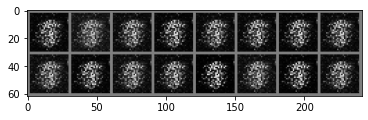

Avg Loss D=0.323394, Avg Loss G=3.681794


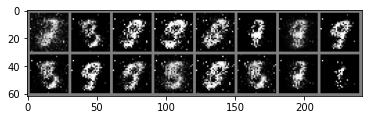

Avg Loss D=0.698719, Avg Loss G=2.002184


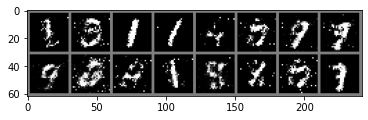

Avg Loss D=0.813047, Avg Loss G=1.685653


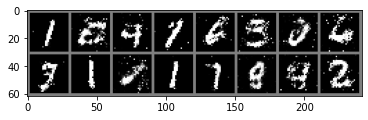

Avg Loss D=0.914807, Avg Loss G=1.484726


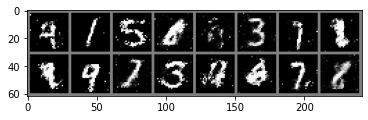

Avg Loss D=0.969024, Avg Loss G=1.370931


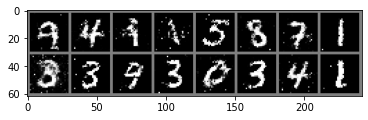

Avg Loss D=0.999325, Avg Loss G=1.322895


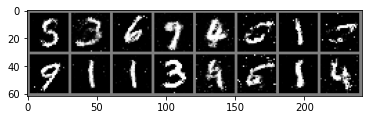

Avg Loss D=1.011079, Avg Loss G=1.301655


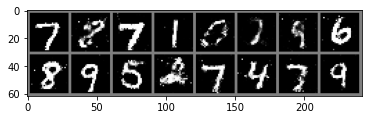

Avg Loss D=1.038383, Avg Loss G=1.240942


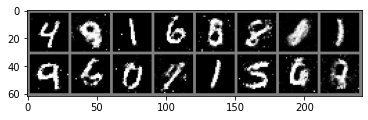

Avg Loss D=1.047244, Avg Loss G=1.227217


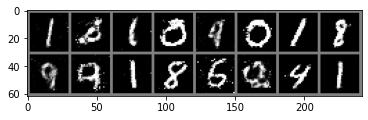

Avg Loss D=1.063626, Avg Loss G=1.207434


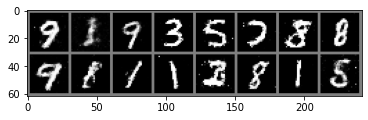

In [15]:
if(__name__=="__main__"):

    root_dir = "/gdrive/My Drive/ml_colab/week14"
    output_dir = os.path.join(root_dir, "output")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    config = {"model_name":"epoch_{0:d}.pt".format(10),
              "root_dir":root_dir,
              "output_dir":output_dir,
              "d_input_node":784,
              "d_hidden_node":256,
              "d_output_node":1,
              "g_input_node":100,
              "g_hidden_node":256,
              "g_output_node":784,
              "learn_rate":0.0002,
              "batch_size":100,
              "epoch":100,
              }

    train(config)